In [1]:
import histomicstk as htk
import tifffile as tiff
import glob
import matplotlib.pyplot as plt
import skimage.io
import skimage.measure
import skimage.color
import numpy as np


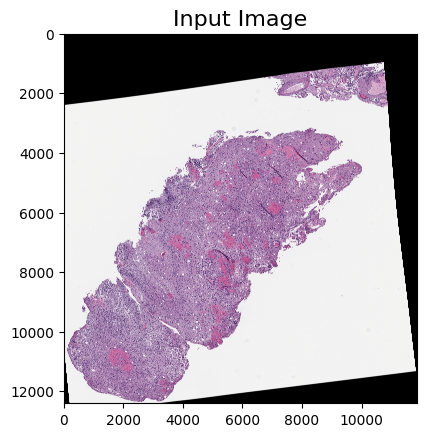

In [2]:
ref_im_path = glob.glob('./example_img/*Raw*.tiff')[0]
ref_im = tiff.TiffReader(ref_im_path)
ref_im_arr = ref_im.asarray()

t1_im_path = glob.glob('./example_img/*T63*HnE*.tiff')[0]
t1_im = tiff.TiffReader(t1_im_path)
t1_im_arr = t1_im.asarray()

t2_im_path = glob.glob('./example_img/*T164*HnE*.tiff')[0]
t2_im = tiff.TiffReader(t2_im_path)
t2_im_arr = t2_im.asarray()

plt.imshow(t2_im_arr)
_ = plt.title('Input Image', fontsize=16)

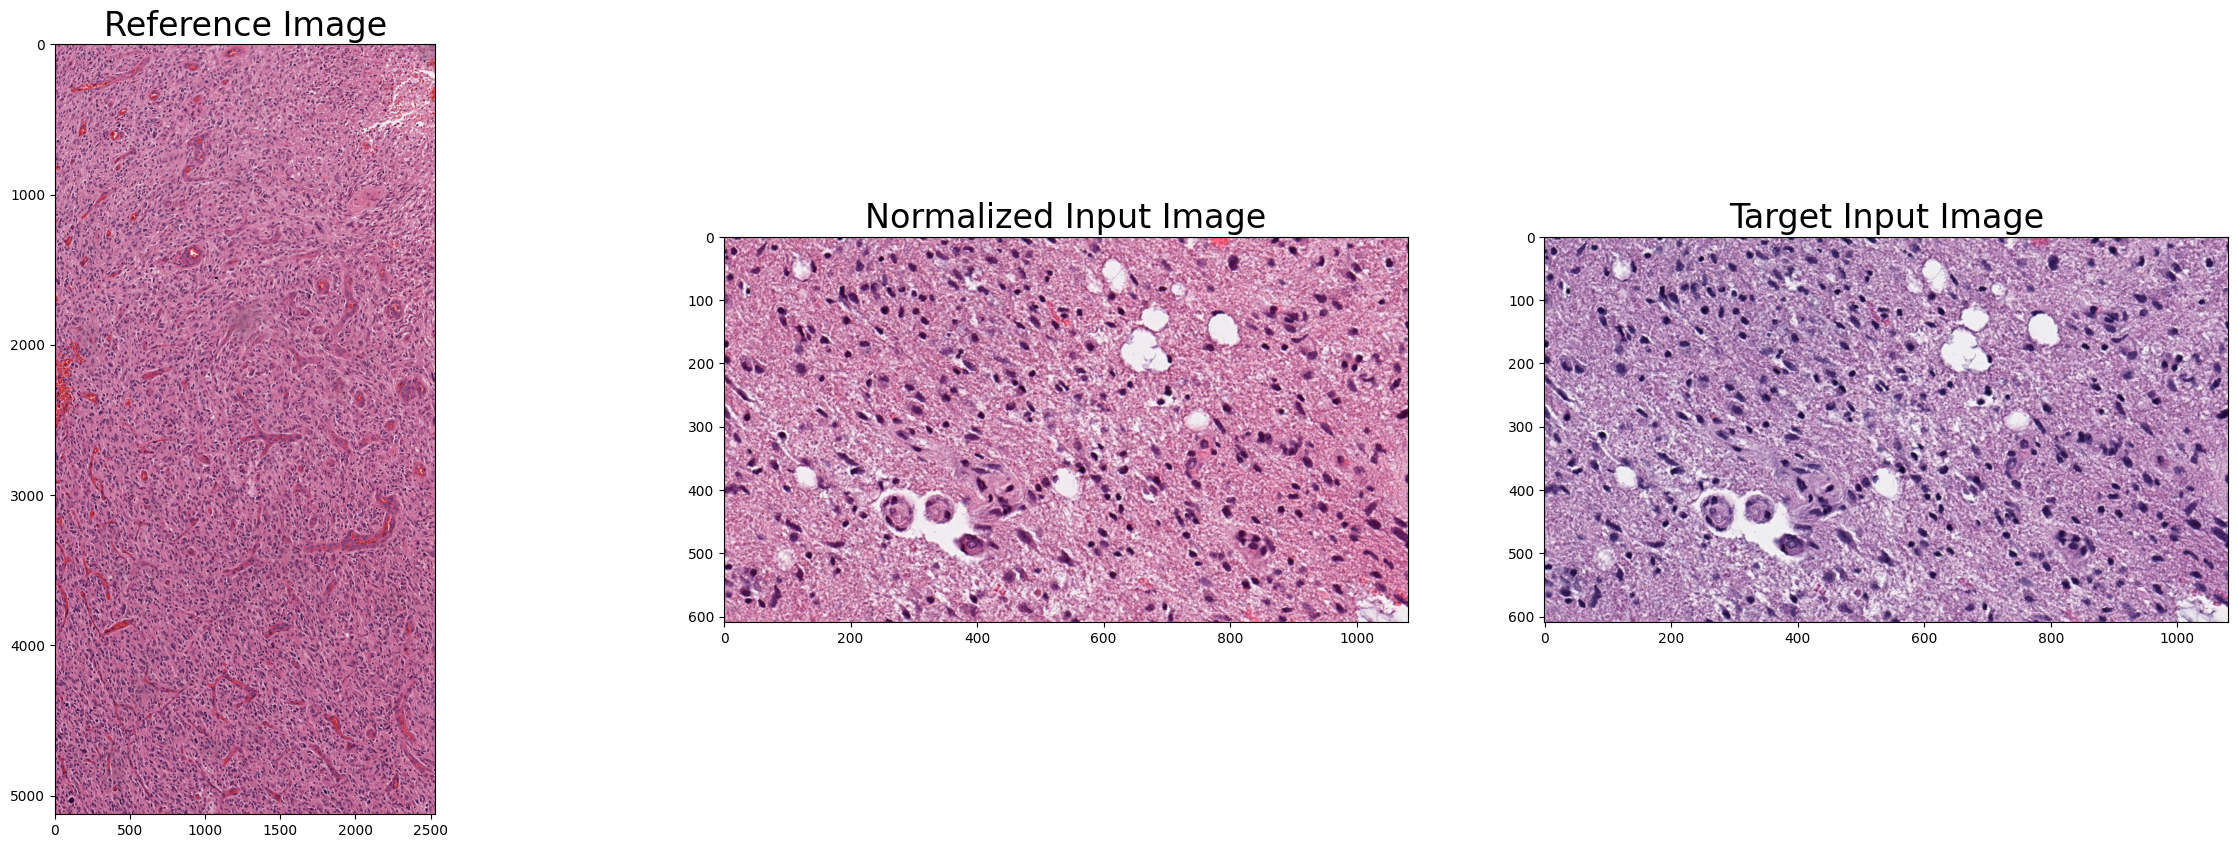

In [14]:
im_nmzd = htk.preprocessing.color_normalization.deconvolution_based_normalization(im_src=t2_im_arr, im_target=ref_im_arr,)
plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.imshow(ref_im_arr)
_ = plt.title('Reference Image', fontsize=24)

plt.subplot(1, 3, 2)
plt.imshow(im_nmzd)
_ = plt.title('Normalized Input Image', fontsize=24)

plt.subplot(1, 3, 3)
plt.imshow(t2_im_arr)
_ = plt.title('Target Input Image', fontsize=24)

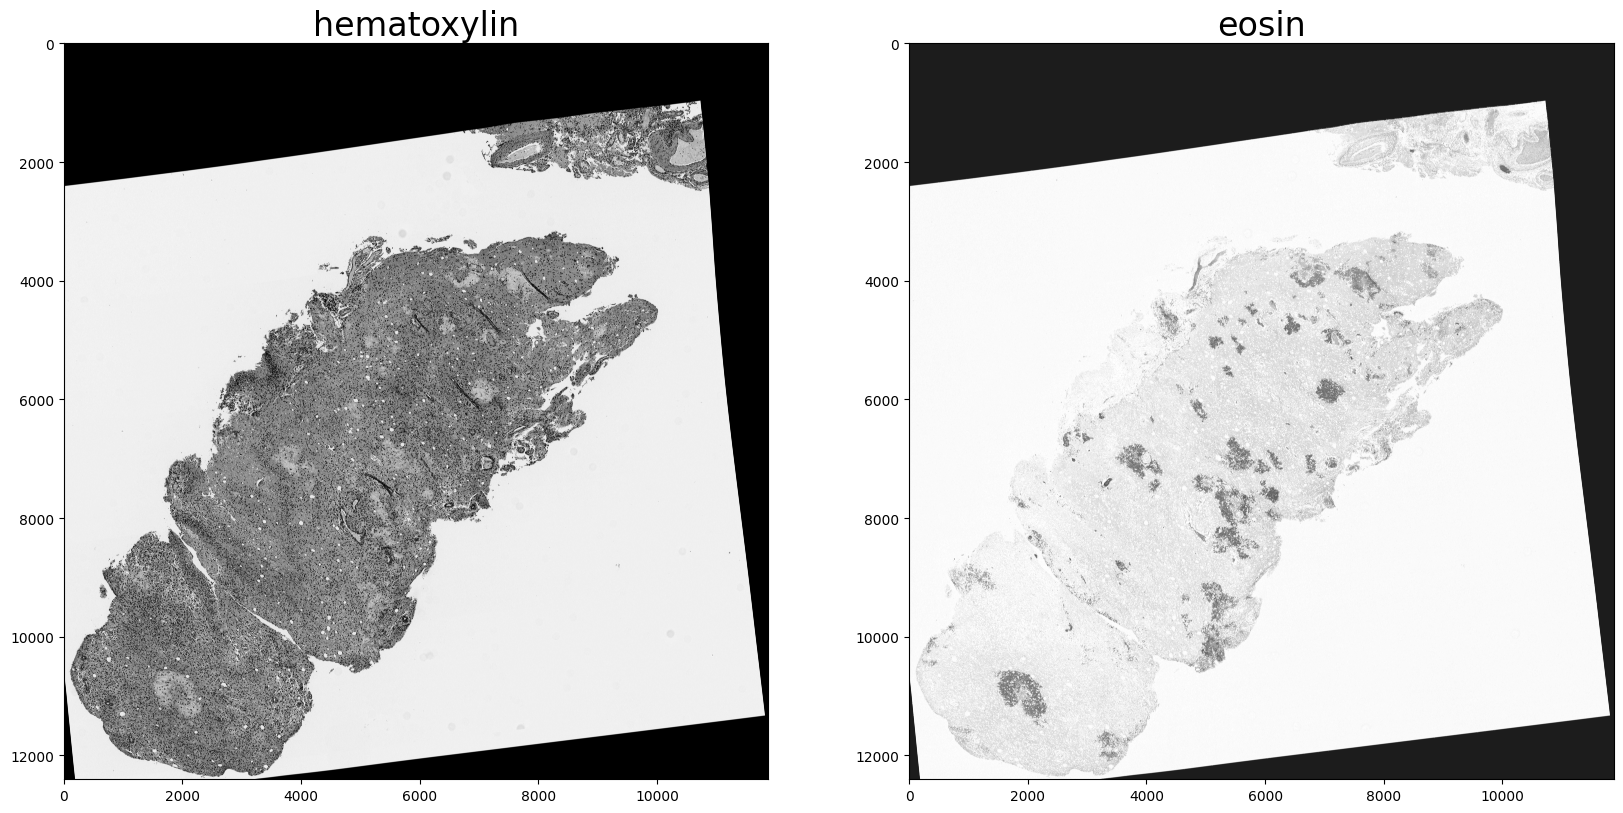

In [3]:


#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

# create stain to color map
stainColorMap = {
    'hematoxylin': [0.52, 0.74, 0.42],
    'eosin':       [0.27, 0.71, 0.65],
    'dab':         [0.27, 0.57, 0.78],
    'null':        [0.00, 0.00, 0.00],
}

# specify stains of input image
stain_1 = 'hematoxylin'   # nuclei stain
stain_2 = 'eosin'         # cytoplasm stain
stain_3 = 'null'          # set to null of input contains only two stains

# create stain matrix
W = np.array([stainColorMap[stain_1],
              stainColorMap[stain_2],
              stainColorMap[stain_3]]).T

# perform standard color deconvolution
im_stains = htk.preprocessing.color_deconvolution.color_deconvolution(t2_im_arr, W).Stains

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_stains[:, :, 0])
plt.title(stain_1, fontsize=24)

plt.subplot(1, 2, 2)
plt.imshow(im_stains[:, :, 1])
_ = plt.title(stain_2, fontsize=24)

In [ ]:
import scipy as sp
import skimage.io
import skimage.measure
import skimage.color

import matplotlib.patches as mpatches

# get nuclei/hematoxylin channel
im_nuclei_stain = im_stains[:, :, 0]

# segment foreground
foreground_threshold = 60

im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
    im_nuclei_stain < foreground_threshold)

# run adaptive multi-scale LoG filter
min_radius = 10
max_radius = 15

im_log_max, im_sigma_max = htk.filters.shape.cdog(
    im_nuclei_stain, im_fgnd_mask,
    sigma_min=min_radius * np.sqrt(2),
    sigma_max=max_radius * np.sqrt(2),
)

# detect and segment nuclei using local maximum clustering
local_max_search_radius = 10

im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
    im_log_max, im_fgnd_mask, local_max_search_radius)

# filter out small objects
min_nucleus_area = 80

im_nuclei_seg_mask = htk.segmentation.label.area_open(
    im_nuclei_seg_mask, min_nucleus_area).astype(np.int)

# compute nuclei properties
objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

print ('Number of nuclei = ', len(objProps))

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(skimage.color.label2rgb(im_nuclei_seg_mask, t2_im_arr, bg_label=0), origin='lower')
plt.title('Nuclei segmentation mask overlay', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(t2_im_arr)
plt.xlim([0, t2_im_arr.shape[1]])
plt.ylim([0, t2_im_arr.shape[0]])
plt.title('Nuclei bounding boxes', fontsize=titlesize)

for i in range(len(objProps)):

    c = [objProps[i].centroid[1], objProps[i].centroid[0], 0]
    width = objProps[i].bbox[3] - objProps[i].bbox[1] + 1
    height = objProps[i].bbox[2] - objProps[i].bbox[0] + 1

    cur_bbox = {
        'type':        'rectangle',
        'center':      c,
        'width':       width,
        'height':      height,
    }

    plt.plot(c[0], c[1], 'g+')
    mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] ,
                               width, height, fill=False, ec='g', linewidth=2)
    plt.gca().add_patch(mrect)

In [5]:
# get nuclei/hematoxylin channel
im_nuclei_stain = im_stains[:, :, 0]
im_nuclei_seg = tiff.TiffReader('./example_img/T164_StarDist2D_prediction.tif')
im_nuclei_seg_mask = im_nuclei_seg.asarray()

In [10]:
import scipy as sp

import matplotlib.patches as mpatches

# compute nuclei properties
objProps = skimage.measure.regionprops(im_nuclei_seg_mask)
print ('Number of nuclei = ', len(objProps))

Number of nuclei =  32379


In [6]:
out_file = './'
just_name = 'T164_StarDist2D_prediction'

# calculate features
df1 = htk.features.compute_fsd_features(im_nuclei_seg_mask)
df2 = htk.features.compute_gradient_features(im_nuclei_seg_mask,im_nuclei_stain)
df3 = htk.features.compute_morphometry_features(im_nuclei_seg_mask)
df4 = htk.features.compute_haralick_features(im_nuclei_seg_mask,im_nuclei_stain)
df1.to_csv(out_file+just_name+"-fourier_shape_descriptors.csv")
df2.to_csv(out_file+just_name+"-gradient.csv")
df3.to_csv(out_file+just_name+"-morphometry.csv")
df4.to_csv(out_file+just_name+"-haralick.csv")